In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import sys
sys.path.append('../')
from trackers import *

In [5]:
with open("../tracker_stubs/ball_detections.pkl" , 'rb') as f:
    ball_positions = pickle.load(f) 

In [7]:
ball_tracker = BallTracker(model_path="../models/yolo5_last.pt")

ball_posi = ball_tracker.interpolate_ball_positions_as_table(ball_positions)

In [8]:
ball_posi

,xmin,ymin,xmax,ymax
0,895.445251,618.047607,912.230347,635.460327
1,895.445251,618.047607,912.230347,635.460327
2,873.914246,638.284424,895.667908,659.140503
3,860.090027,645.889343,881.661865,670.257507
4,847.579468,659.635213,867.032471,681.292399
...,...,...,...,...
209,1185.065552,248.473297,1198.981934,265.607117
210,1185.115845,233.993408,1195.525635,244.392792
211,1184.236450,226.549347,1196.433105,241.980331
212,1180.803955,214.329208,1193.790527,231.511368


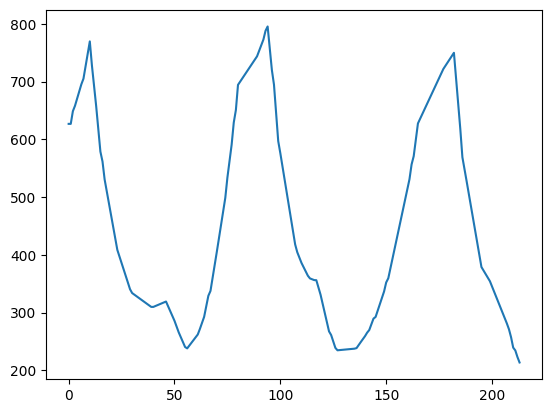

In [40]:
ball_posi['mid_y'] = (ball_posi['ymax'] + ball_posi['ymin'])/2
plt.plot(ball_posi['mid_y'])

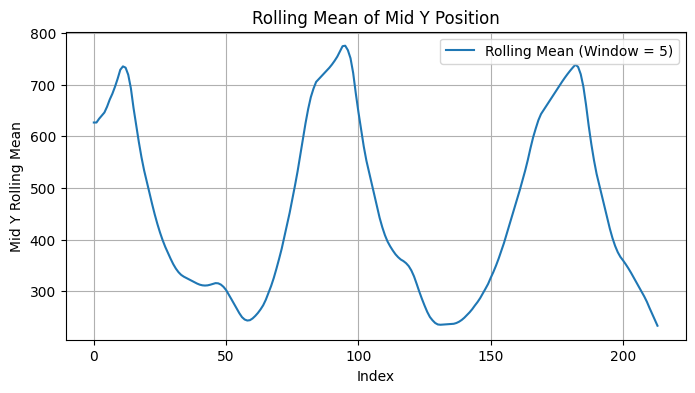

In [16]:
ball_posi['mid_y_rolling_mean'] = ball_posi['mid_y'].rolling(window = 5 , center=False , min_periods = 1).mean()


plt.figure(figsize=(8, 4))
plt.plot(ball_posi['mid_y_rolling_mean'], label='Rolling Mean (Window = 5)')
plt.title('Rolling Mean of Mid Y Position')
plt.xlabel('Index')
plt.ylabel('Mid Y Rolling Mean')
plt.legend()
plt.grid(True)
plt.show()

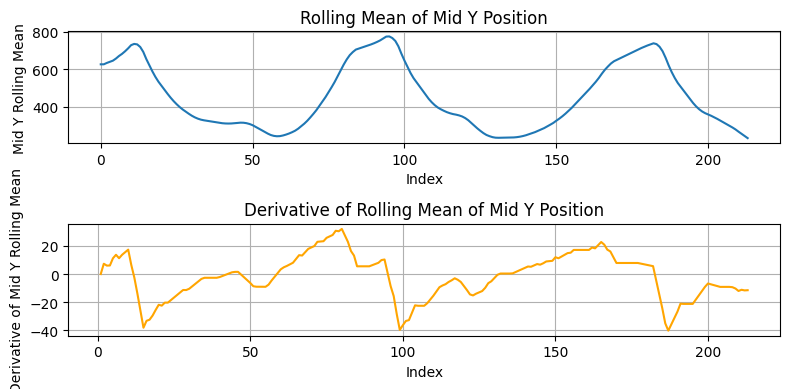

In [41]:
ball_posi['mid_y_rolling_mean_derivative'] = ball_posi['mid_y_rolling_mean'].diff()

# Plot the rolling mean
plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plt.plot(ball_posi['mid_y_rolling_mean'], label='Rolling Mean (Window = 5)')
plt.title('Rolling Mean of Mid Y Position')
plt.xlabel('Index')
plt.ylabel('Mid Y Rolling Mean')
plt.grid(True)

# Plot the derivative of the rolling mean
plt.subplot(2, 1, 2)
plt.plot(ball_posi['mid_y_rolling_mean_derivative'], label='Derivative of Rolling Mean', color='orange')
plt.title('Derivative of Rolling Mean of Mid Y Position')
plt.xlabel('Index')
plt.ylabel('Derivative of Mid Y Rolling Mean')
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
ball_posi

ball_posi['del_y'] = ball_posi['mid_y_rolling_mean_derivative']


6.523406982421875

# Finding out the frame no where the ball starts to change in direction

In [44]:
ball_posi['ball_hit'] = 0

minimum_change_frame_for_hit = 25 # it needs to stay in the same direction for atleast 25 frames

for i in range(1 , len(ball_posi) - int((1.2*minimum_change_frame_for_hit))):

    count = 0

    negative_change = ball_posi['del_y'].iloc[i] > 0 and ball_posi['del_y'].iloc[i+1] < 0   # derivative changes 
    positive_change = ball_posi['del_y'].iloc[i] < 0 and ball_posi['del_y'].iloc[i+1] > 0 

    if negative_change or positive_change:


        # next 25 frames should follow the same direction 
        for j in range(i+1 , i+ int(1.2*minimum_change_frame_for_hit)):
            negative_check = ball_posi['del_y'].iloc[j] < 0 and ball_posi['del_y'].iloc[i] > 0       
            positive_check = ball_posi['del_y'].iloc[j] > 0 and ball_posi['del_y'].iloc[i] < 0

            if negative_check and negative_change :    
                count+= 1
            elif positive_check and positive_change:
                count+=1
        
    if (count >= minimum_change_frame_for_hit):
        ball_posi['ball_hit'].iloc[i]= 1
    

                     

/tmp/ipykernel_7615/1748406790.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ball_posi['ball_hit'].iloc[i]= 1
/tmp/ipykernel_7615/1748406790.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [50]:
filtered_list = ball_posi.index[ball_posi['ball_hit'] == 1].values.tolist()

print(filtered_list)

[11, 58, 95, 131, 182]


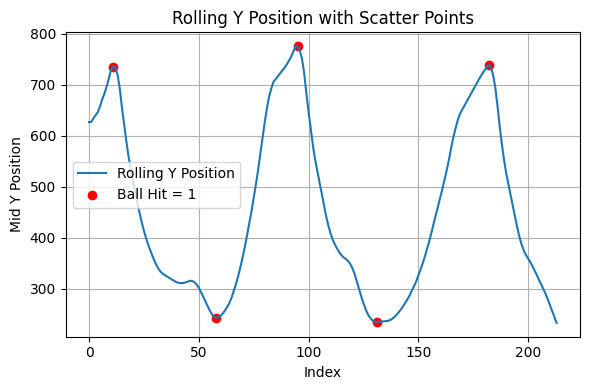

In [56]:
plt.figure(figsize=(6, 4))
plt.plot(ball_posi['mid_y_rolling_mean'], label='Rolling Y Position')
plt.title('Rolling Y Position with Scatter Points')
plt.xlabel('Index')
plt.ylabel('Mid Y Position')
plt.grid(True)

# Scatter points where ball_hit is 1
plt.scatter(filtered_list, ball_posi['mid_y_rolling_mean'].iloc[filtered_list], color='red', label='Ball Hit = 1')

plt.legend()
plt.tight_layout()
plt.show()